In [2]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [20]:
# Data input and preprocessing

# Filenames:
# DEXCAUS.csv  DEXJPUS.csv  DEXMXUS.csv  DEXUSUK.csv DEXCHUS.csv  DEXKOUS.csv  DEXUSEU.csv  DTWEXM.csv

# Reads in currency exchange rate data
filename='DEXUSEU' # Filename
dataset = pd.read_csv('data/'+filename+'.csv') # Reads in CSV file
exchangevalues = dataset.iloc[:, 1:2] # Selects columns

# Replaces missing data (represented by '.') with zeros ('0')
mask=exchangevalues=='.'
exchangevalues[mask] = '0'

# Reshapes column into form compatible with RNN inputs
exchangevalues=np.array(exchangevalues)
exchangevalues=np.matrix([float(x) for x in exchangevalues])
exchangevalues=exchangevalues.transpose()

# Fills in missing and outlier values by taking average between adjacent timesteps
mean,std=np.mean(exchangevalues),np.std(exchangevalues) # Computes mean and std
indices = [i for i ,x in enumerate(exchangevalues) if x<mean-2.5*std] # Finds indices of zero and outlier values
for i in indices:
    # First, checks the initial and final elements of the list
    # If any of these are zero, set them to be equal to their adjacent values
    if i==0:
        exchangevalues[i] = exchangevalues[i+1]
    elif i==len(exchangevalues)-1:
        exchangevalues[i] = exchangevalues[i-1]
    
    # For the rest of the elements, set them to be the average of their adjacent values
    exchangevalues[i] = 0.5*(exchangevalues[i+1]+exchangevalues[i-1]) 
    
# Initializes the training set
training_set = exchangevalues
N_total_timesteps = len(training_set) # The total number of timesteps in the dataset

# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

# Train/test set parameters
N_timesteps = 60 # Number of timesteps in each training epoch
N_test_timesteps = int(0.15*len(training_set_scaled)) # Number of timesteps for the test set

# Creating a data structure with N timesteps and 1 output
X_train = []
y_train = []
for i in range(N_timesteps, len(training_set)-N_test_timesteps):
    X_train.append(training_set_scaled[i-N_timesteps:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_test = []
y_test = []
for i in range(len(training_set)-N_test_timesteps, len(training_set)):
    X_test.append(training_set_scaled[i-N_timesteps:i, 0])
    y_test.append(training_set_scaled[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))
y_test = np.reshape(y_test, (y_test.shape[0], 1))

print('training_set shape',training_set.shape)
print('X_train shape',X_train.shape)
print('y_train shape',y_train.shape)
print('X_test shape',X_test.shape)
print('y_test shape',y_test.shape)

training_set shape (2610, 1)
X_train shape (2159, 60, 1)
y_train shape (2159, 1)
X_test shape (391, 60, 1)
y_test shape (391, 1)


/home/ansonl/.local/lib/python3.5/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/home/ansonl/.local/lib/python3.5/site-packages/pandas/core/frame.py:3163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._where(-key, value, inplace=True)


In [4]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')


Using TensorFlow backend.


In [5]:
# Fit the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 20, batch_size = 32)

Epoch 1/20
2159/2159 [==============================] - 14s 7ms/step - loss: 0.0564
Epoch 2/20
2159/2159 [==============================] - 12s 6ms/step - loss: 0.0086
Epoch 3/20
2159/2159 [==============================] - 12s 5ms/step - loss: 0.0063
Epoch 4/20
2159/2159 [==============================] - 12s 5ms/step - loss: 0.0070
Epoch 5/20
2159/2159 [==============================] - 11s 5ms/step - loss: 0.0051
Epoch 6/20
2159/2159 [==============================] - 11s 5ms/step - loss: 0.0056
Epoch 7/20
2159/2159 [==============================] - 11s 5ms/step - loss: 0.0048
Epoch 8/20
2159/2159 [==============================] - 11s 5ms/step - loss: 0.0048
Epoch 9/20
2159/2159 [==============================] - 11s 5ms/step - loss: 0.0046
Epoch 10/20
2159/2159 [==============================] - 11s 5ms/step - loss: 0.0046
Epoch 11/20
2159/2159 [==============================] - 11s 5ms/step - loss: 0.0039
Epoch 12/20
2159/2159 [==============================] - 11s 5ms/step - lo

In [23]:
# Makes preductions using the test set and the trained RNN model
predicted_values = regressor.predict(X_test)

# Inverts feature scaling transformation
y_train = sc.inverse_transform(y_train)
y_test = sc.inverse_transform(y_test)
predicted_values = sc.inverse_transform(predicted_values)

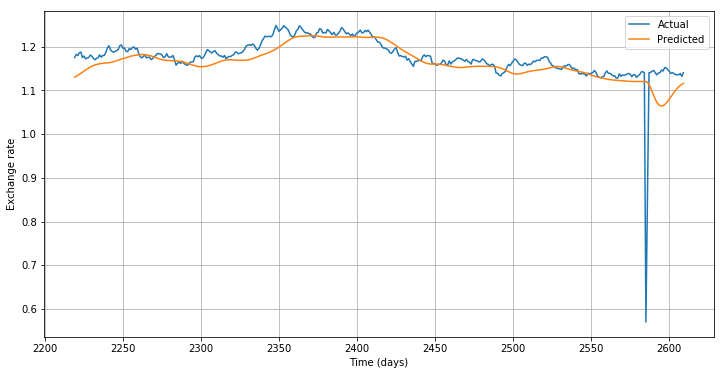

In [35]:
# Does plotting
plt.figure(figsize=(12,6))

#plt.plot(range(N_timesteps, len(training_set)-N_test_timesteps),y_train,label = 'Training data')
plt.plot(range(len(training_set)-N_test_timesteps, len(training_set)),y_test,label = 'Actual')
plt.plot(range(len(training_set)-N_test_timesteps, len(training_set)),predicted_values,label = 'Predicted')
#plt.plot(range(len(training_set)-N_test_timesteps, len(training_set)),predicted_values-y_test)


plt.xlabel('Time (days)')
plt.ylabel('Exchange rate')
#plt.ylim(1.2,1.4)
plt.legend()
plt.grid(True)